# Summary
This notebook deomnstrates very basic usage of the loading python modules. Datasets used include the Ookla tile data, 
Statistics Canada hexagons and Pseudo-household population distribution. The data is geographic info on internet speed 
test results as well as population data and nominal access to internet based on the National Broadband Map. 

In [1]:
import sys
sys.path.append("..")
# Useful for testing/debugging in Jupyter
# %load_ext autoreload
# %autoreload 1
# %aimport src.datasets.loading.statcan 

import pandas as pd
import matplotlib.pyplot as plt 
from src.datasets.loading import statcan
from src.datasets.loading import ookla

## Load Datasets
Load the data and display samples of their content.

In [2]:
#calcs take about 5 minutes
hex_data = statcan.hexagon_geometry().merge(statcan.hexagons_phh(), how='right', on="HEXuid_HEXidu")
tiles = ookla.canada_speed_tiles()
hex_data = hex_data.to_crs(tiles.crs)

In [3]:
tiles.head(2)

,quadkey,geometry,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,conn_type,year,quarter
0,302312221203002,"POLYGON ((-72.72949 45.42544, -72.72400 45.425...",79946,34351,14,2,1,fixed,2019,3
1,302312221203002,"POLYGON ((-72.72949 45.42544, -72.72400 45.425...",410409,440056,4,1,1,fixed,2019,4


In [4]:
hex_data.head(2)

,HEXuid_HEXidu,geometry,SumPop_2016_SommePop,SumURD_2016_SommeRH,SumTD_2016_SommeTL,Avail_5_1_75PctPlus_Dispo,Avail_50_10_Gradient_Dispo,Pop2016,TDwell2016_TLog2016,URDwell2016_RH2016,PHH_Count,Common_Type
0,AB49281131,"POLYGON ((-113.06357 49.27754, -113.08366 49.2...",5-25,<5,<5,T,0,17.040808,3.893131,3.893131,37,18
1,AB49281132,"POLYGON ((-113.18413 49.27754, -113.20422 49.2...",5-25,<5,<5,T,>50% - 75%,24.196351,3.917342,3.792342,54,20


## Compute Spatial Joins 
Merge data based on it's location. For this data, identify smaller Ookla tiles which are inside the 
federal government hexagon areas.

In [5]:
spatial_join = hex_data.sjoin(tiles) # calc takes about 3 minutes

In [6]:
spatial_join.head(2)

,HEXuid_HEXidu,geometry,SumPop_2016_SommePop,SumURD_2016_SommeRH,SumTD_2016_SommeTL,Avail_5_1_75PctPlus_Dispo,Avail_50_10_Gradient_Dispo,Pop2016,TDwell2016_TLog2016,URDwell2016_RH2016,...,index_right,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,conn_type,year,quarter
0,AB49281131,"POLYGON ((-113.06357 49.27754, -113.08366 49.2...",5-25,<5,<5,T,0,17.040808,3.893131,3.893131,...,1756020,212133330023300,10039,2350,38,1,1,fixed,2020,1
0,AB49281131,"POLYGON ((-113.06357 49.27754, -113.08366 49.2...",5-25,<5,<5,T,0,17.040808,3.893131,3.893131,...,1756019,212133330023300,1117,383,78,2,1,fixed,2019,4


## Aggregate Join Info
The above spatial join adds hexagon information to individual tiles, and we'd like to 
aggregate and calculate some statistics on the overall hexagon areas.

In [7]:
grps = spatial_join.loc[lambda s:(s.year ==2022) & (s.conn_type=='fixed')].groupby('HEXuid_HEXidu')
hex_aggs = pd.concat([
    grps['avg_d_kbps'].mean(),
    grps['avg_u_kbps'].mean(),
    grps['avg_lat_ms'].mean(),
    grps['tests'].sum(),
    grps['devices'].sum(),
],axis=1)

In [8]:
hex_aggs.head(5)

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
HEXuid_HEXidu,,,,,
AB49001120,34719.250000,9964.500000,35.125000,72,13
AB49001128,5666.000000,2479.000000,103.000000,10,1
AB49001134,140219.000000,5484.000000,122.000000,2,2
AB49001135,63298.333333,6516.000000,47.666667,12,3
AB49021102,25361.666667,9442.666667,93.333333,33,4


In [9]:
hex_data_w_speeds = hex_data.merge(hex_aggs, left_on='HEXuid_HEXidu',right_index=True)

## Visualizations
Plot the hexagons accross Canada, and also compare population of hexagon area to dowload speed of 50 Mbps.

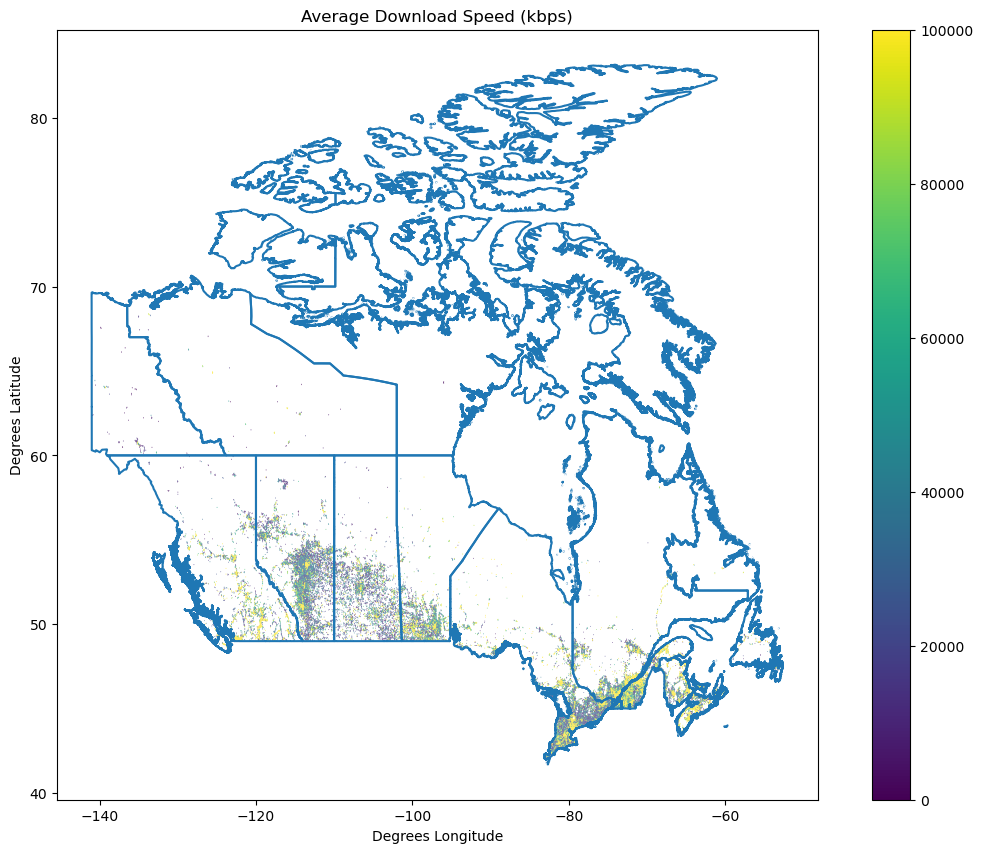

In [10]:
ax = hex_data_w_speeds.plot(column='avg_d_kbps', legend=True, vmin=0, vmax=100e3, figsize=(14,10))
ax.set(xlabel="Degrees Longitude", ylabel="Degrees Latitude")
ax.set_title("Average Download Speed (kbps)")
statcan.boundary('provinces').to_crs(hex_data_w_speeds.crs).boundary.plot(ax=ax);

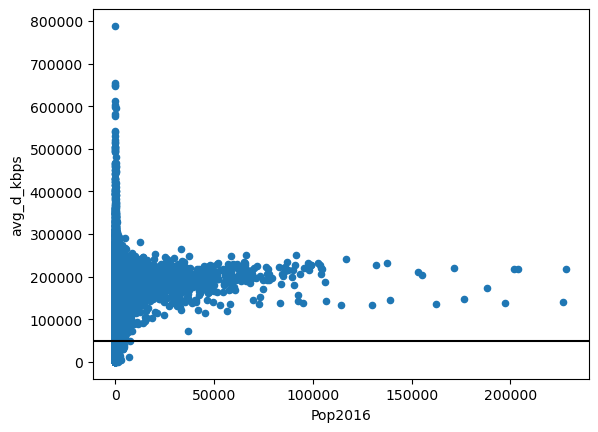

In [11]:
hex_data_w_speeds.plot.scatter(x='Pop2016',y='avg_d_kbps')
ax = plt.gca()
ax.axhline(50e3,color='k', zorder=100);